In [20]:
import ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import scipy
from scipy import signal
import neurokit2 as nk
import random
# %matplotlib inline 
import pyhrv
import ipynb

# functions for features extraction
from ipynb.fs.full.ECG_features import get_ecgfeatures
from ipynb.fs.full.EDA import get_edaindex, get_edafeatures
from ipynb.fs.full.BVP import get_bvpfeatures, bvp_prep

In [2]:
# Dataset reading
class read_data_of_one_subject:
            """Read data from WESAD dataset"""
            def __init__(self, path, subject):
                self.keys = ['label', 'subject', 'signal']
                self.signal_keys = ['wrist', 'chest']
                self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
                self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
                #os.chdir(path)
                #os.chdir(subject)
                with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
                    data = pickle.load(file, encoding='latin1')
                self.data = data

            def get_labels(self):
                return self.data[self.keys[0]]

            def get_wrist_data(self):
                """"""
                #label = self.data[self.keys[0]]
                #assert subject == self.data[self.keys[1]]
                signal = self.data[self.keys[2]]
                wrist_data = signal[self.signal_keys[0]]
                #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
                #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
                return wrist_data

            def get_chest_data(self):
                """"""
                signal = self.data[self.keys[2]]
                chest_data = signal[self.signal_keys[1]]
                return chest_data

In [3]:
# Set up empty dataframes for the features
ecgfeatures = pd.DataFrame(None, columns= ['HR_mean', 'HR_min', 'HR_max', 'HR_std', 'SDNN', 'SDANN', 'RMSSD', 'SDSD','pNN50', 'pNN20', 
                                    'abs_power_VLF', 'abs_power_LF', 'abs_power_HF', 'tot_power', 'LF/HF', 
                                    'peak_vlf', 'peak_lf', 'peak_hf', 'norm_power_LF', 'norm_power_HF'])
edafeatures = None
bvpfeatures = None

fs = 700 # sampling frequency
y = []
data_set_path= "C:/Users/JackC/Documents/EPO4/WESAD/WESAD/" # Folder path
#data_set_path= "C:/Users/riche/Downloads/WESAD/WESAD/" # Folder path
#data_set_path = "C:/Users/Adnane/Downloads/WESAD/WESAD/"

for i in range(16): # 15 subjects
    subject = 'S'+str(i+2) # Cycle through S2 to S17
    print(subject)
    if subject != 'S12': # Skip S12, because it does not exist
        # Object instantiation
        obj_data = {}

        # Accessing class attributes and method through objects
        obj_data[subject] = read_data_of_one_subject(data_set_path, subject)

        chest_data_dict = obj_data[subject].get_chest_data()
        wrist_data_dict = obj_data[subject].get_wrist_data()
        chest_dict_length = {key: len(value) for key, value in chest_data_dict.items()}
        wrist_dict_length = {key: len(value) for key, value in wrist_data_dict.items()}
        # Get labels
        labels = obj_data[subject].get_labels()

        for label in range(1,5): # for every state of stress
            
            baseline = np.asarray([idx for idx,val in enumerate(labels) if val == label])

            eda_base=chest_data_dict['EDA'][baseline,0] # Select the EDA data
            ecg_base=chest_data_dict['ECG'][baseline,0] # Select the ECG data
            resp_base=chest_data_dict['Resp'][baseline,0] # Select the respiration data
            baseline_BVP = baseline * 64 // fs
            bvp_base=wrist_data_dict['BVP'][baseline_BVP,0] # Select the BVP data

            #tonic, phasic, start, end = get_edaindex(eda_base, fs)

            #Matching the index of the phasic to the other signals
            #ecg = ecg_base[start: end]
            #resp = resp_base[start: end]
            #tonic = tonic[start: end]
            duration = 25

            # Multiple smaller samples per signal
            samples = 10 # specify amount of samples
            
            for j in range(samples):

                # adding the labels to y
                if label==3 or label==4: # if amusement or medidation, classify as non-stress
                    y.append(1)
                else:
                    y.append(label)

                # choosing a random begin point for smaller sample
                begin = random.randint(0, min(len(ecg_base),len(ecg_base))- duration * fs)

                ecg = ecg_base[begin: begin + duration*fs]
                eda = eda_base[begin: begin + duration*fs]
                bvp = bvp_base[begin: begin + duration*fs]

                 # splitting sample into 10 smaller even-sized parts
                #ecg = ecg_base[int(len(ecg_base)* (j/samples)) : int(len(ecg_base)* ((j+1)/samples))]
                #eda = eda_base[int(len(eda_base)* (j/samples)) : int(len(eda_base)* ((j+1)/samples))]

                # getting the eda and ecg features
                index = subject + str(label) + str(j)
                tonic, phasic, start, end = get_edaindex(eda, fs)
                edafeatures = get_edafeatures(index, edafeatures, phasic, tonic, fs)
                ecgfeatures = get_ecgfeatures(ecg, fs, ecgfeatures, index)
                
                bvpfeature = get_bvpfeatures(bvp)
                bvpfeatures = pd.concat([bvpfeatures, bvpfeature])

            ## One sample per signal
#
            #if label==3 or label==4:
            #        y.append(1)
            #else:
            #    y.append(label)
#
            #index = subject + str(label) 
            #edafeatures = get_edafeatures(index, edafeatures, phasic, tonic, fs)
            #ecgfeatures = get_ecgfeatures(ecg, fs, ecgfeatures, index)


            # Plot a signal

            # t=np.arange(0,eda_base.size*(1/fs),(1/fs))
            # t=t[:eda_base.size]
            
            # plt.figure(figsize=(12,4))
            # plt.plot(t, eda_base)
            # plt.xlabel('$Time (s)$') 
            # plt.ylabel('$signal$')

S2
S3
S4
S5
S6
S7
S8
S9
S10
S11
S12
S13
S14
S15
S16
S17


In [4]:
bvp_filt = bvp_prep(bvpfeatures) # remove nan and inf in BVP features

# saving the feature data in csv files
edafeatures.to_csv("EDA_features.csv")
ecgfeatures.to_csv("ECG_features.csv")
bvp_filt.to_csv("BVP_features.csv")

features1 = pd.merge(ecgfeatures, edafeatures, left_index=True, right_index=True)
features1.reset_index(drop=True, inplace=True)

features = pd.merge(features1, bvp_filt, left_index=True, right_index=True)
features.to_csv("features_"+str(samples)+"_samp.csv") # csv for smaller samples

c:\Users\JackC\Documents\EPO4-C2\BVP.ipynb:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "\n",
c:\Users\JackC\Documents\EPO4-C2\BVP.ipynb:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "\n",


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm

In [63]:
total_features = features
y_feat = y

# Performing PCA

In [74]:
# normalize data
scaler = StandardScaler().fit(features)
X_train = scaler.transform(features)

n = 25
# perform PCA
pca = PCA(n_components=n)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
x_train = X_train_pca[:,0:3] # Three best features

# plot two best features
# plt.figure(figsize=(8,6))
# plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y)

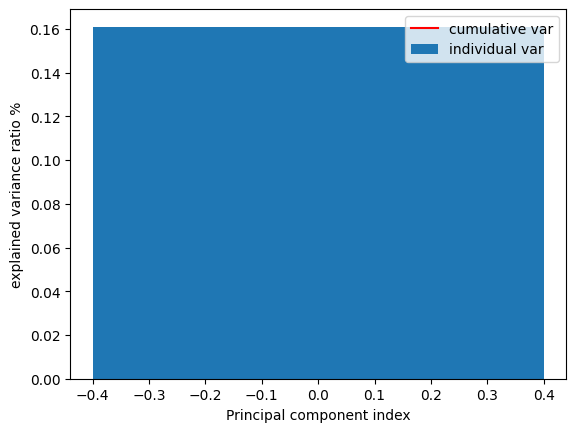

In [75]:
# plot feature variance
plt.bar(range(0,n), pca.explained_variance_ratio_, label="individual var");
plt.step(range(0,n), np.cumsum(pca.explained_variance_ratio_),'r', label="cumulative var");
plt.xlabel('Principal component index'); plt.ylabel('explained variance ratio %');
plt.legend()

In [76]:
# Splitting the data in train and test data
print(len(x_train))
X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.2, random_state=5)

# Scaling the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

600


# Logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
Y_test_pred = logistic_model.predict(X_test)
log_score = logistic_model.score(X_test,y_test)

# SVM

In [11]:
from sklearn import datasets, svm
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)
Y_test_pred = svm_model.predict(X_test)
svm_score = svm_model.score(X_test,y_test)

# Neural Networks

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

val_accuracies = []
for i in range(5): # run 5 times with 5 random states to determine model accuracy
    # Splitting the data in train and test data
    X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.2, random_state= i + 1)

    # Scaling the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    ## Convert labels to categorical
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    # Define the feedforward neural network
    neural_model = Sequential()
    neural_model.add(Dense(64, activation='relu', input_shape=(3,)))
    neural_model.add(Dense(64, activation='relu'))
    neural_model.add(Dense(64, activation='relu'))
    neural_model.add(Dense(64, activation = 'relu'))
    neural_model.add(Dropout(0.5))
    neural_model.add(Dense(3, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    neural_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Train the model
    # history = model.fit(X_train_pca, y_train, validation_data=(X_test_pca, y_test), epochs=45, batch_size=100, verbose=2)
    history = neural_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=45, batch_size=100, verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    val_accuracies.append(val_accuracy) # accuracy score

print(val_accuracies)
avg_val_accuracy = sum(val_accuracies) / len(val_accuracies) # average of accurracy scores
print("Average Validation Accuracy:", avg_val_accuracy)

[0.8583333492279053, 0.8916666507720947, 0.8916666507720947, 0.8666666746139526, 0.8666666746139526]
Average Validation Accuracy: 0.875


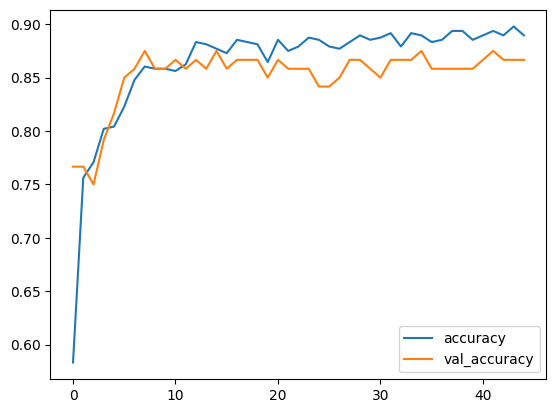

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

# AdaBoost

In [14]:
# Import the AdaBoost classifier
from sklearn.ensemble import AdaBoostClassifier
Ada_scores = [[]]*200
for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.3, random_state= i+1)
    # Create adaboost classifer object
    abc= AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=5)

    # Train Adaboost Classifer
    adaboost_model = abc.fit(X_train, y_train)


#Predict the response for test dataset
# y_pred = model1.predict(X_test)
    score30= adaboost_model.score(X_test, y_test)
    Ada_scores[i] = score30
print(Ada_scores)
print(np.mean(Ada_scores))
#predictions = adaboost_model.predict(X_test)
#print(predictions != y_test)
#print(score30)

[0.8666666666666667, 0.8777777777777778, 0.8388888888888889, 0.8444444444444444, 0.8277777777777777, 0.8388888888888889, 0.85, 0.8722222222222222, 0.8222222222222222, 0.8444444444444444, 0.8111111111111111, 0.85, 0.8888888888888888, 0.8666666666666667, 0.8277777777777777, 0.8388888888888889, 0.85, 0.8444444444444444, 0.8222222222222222, 0.8611111111111112, 0.85, 0.8611111111111112, 0.8666666666666667, 0.8833333333333333, 0.8333333333333334, 0.8611111111111112, 0.8888888888888888, 0.8611111111111112, 0.8666666666666667, 0.8444444444444444, 0.8333333333333334, 0.8277777777777777, 0.8333333333333334, 0.8277777777777777, 0.8333333333333334, 0.8444444444444444, 0.85, 0.8388888888888889, 0.8611111111111112, 0.8666666666666667, 0.8222222222222222, 0.85, 0.8388888888888889, 0.8555555555555555, 0.8333333333333334, 0.8833333333333333, 0.7888888888888889, 0.85, 0.8444444444444444, 0.8222222222222222, 0.8555555555555555, 0.85, 0.8777777777777778, 0.8388888888888889, 0.8944444444444445, 0.877777777

0.8483333333333334
120


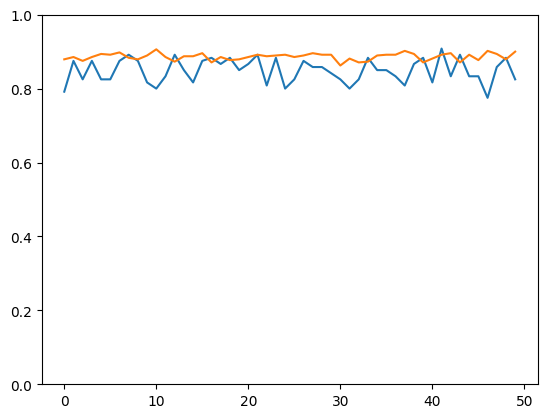

In [15]:
from sklearn.tree import DecisionTreeClassifier
scores_ada = []
trainscores_ada = []
for i in range (50):
      dtree = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1)
      adbclassifier = AdaBoostClassifier(base_estimator=dtree,
                                    n_estimators=100,
                                    learning_rate=1,
                                    algorithm = 'SAMME',
                                    random_state=1)
      X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.2, random_state= i+1)
      adbclassifier.fit(X_train, y_train)
      scores_ada.append(adbclassifier.score(X_test,y_test))
      trainscores_ada.append(adbclassifier.score(X_train,y_train))
print(np.mean(scores_ada))
print(len(X_test))
plt.ylim(0,1)
plt.plot(scores_ada)
plt.plot(trainscores_ada)

# XGBoost

In [16]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
label = LabelEncoder()
y2 = label.fit_transform(y)
y2 = list(y2)
xg_scores = []
xg_trainscores = []
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(x_train, y2, test_size=0.2, random_state= i+1)
    xgb_clf = XGBClassifier(n_estimators = 500,
                            learning_rate = 1,
                            eval_metric = "logloss",
                            early_stopping_rounds = 5,
                            n_jobs = -1,
                            )
    xgb_clf.fit(X_train, y_train,                    
                eval_set = [(X_test,y_test)],
                verbose = False)
    pred_test = xgb_clf.predict(X_test)
    test_score = accuracy_score(pred_test, y_test)
    xg_scores.append(test_score)
    pred_test = xgb_clf.predict(X_train)
    train_score = accuracy_score(pred_test, y_train)
    xg_trainscores.append(train_score)
print(np.mean(xg_scores))
print(np.mean(xg_trainscores))


ModuleNotFoundError: No module named 'xgboost'

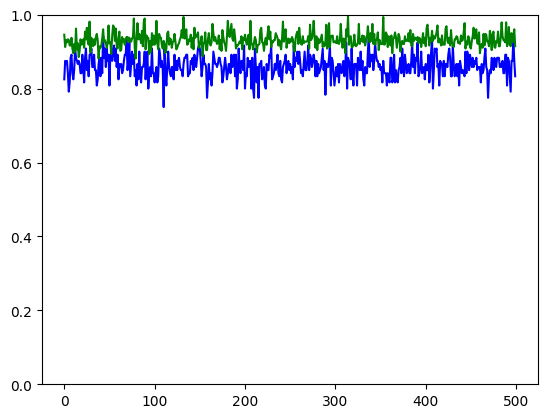

In [ ]:
plt.ylim(0,1)
plt.plot(xg_scores, c = 'blue')
plt.plot(xg_trainscores, c = 'green')


In [ ]:
from sklearn.metrics import accuracy_score
pred_test = xgb_clf.predict(X_test)
test_score = accuracy_score(pred_test, y_test)
print("Test score:", np.round(test_score,2))
print(pred_test)

Test score: 0.83
[0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0
 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 1 1 1 1 0 1]


In [ ]:
print(np.max(Ada_scores))

0.9277777777777778


# Random forest method

In [77]:
#from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# define the model
randomf_model = RandomForestClassifier()

# fit/train the model on all features
randomf_model.fit(X_train, y_train)
Y_test_pred = randomf_model.predict(X_test)

# score
rf_score=randomf_model.score(X_test, y_test)

# get feature importance
importance = randomf_model.feature_importances_

#creat a dictionary with key=indices, and values=importance
important_features_dict = {}
for idx, val in enumerate(importance):
    important_features_dict[idx] = val
# sorting 
important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)
# print indices of top 5 features
print(important_features_list[:5])
#plt.plot(importance)

[0]


# Scores

In [ ]:
y_test_cat = to_categorical(y_test)
y_test1 = y_test_cat.astype('int64')
testYarg = np.argmax(y_test1, axis = 1)

In [ ]:
# function which gives predicted and correct values with missclassifications and scores for neural network
def model_predict_neural(X_test, y_test1, model):
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis = 1)
    y_test1 = y_test1.astype('int64')
    testYarg = np.argmax(y_test1, axis = 1)
    miss_class = np.where(predictions != testYarg)
    miss_class = miss_class[0]
    print("Neural network")
    print("Predicted:",predictions)
    print("Correct:  ",testYarg)
    print("Index missclassified:", miss_class)
    print("Score:", val_accuracy, "\n")
    return predictions, miss_class, testYarg

In [ ]:
# function which gives predicted and correct values with missclassifications and scores for rest models
def model_predict(X_test, y_test1, model):
    predictions = model.predict(X_test)
    #y_test1 = y_test1.astype('int64')
    #testYarg = np.argmax(y_test1, axis = 1)
    miss_class = np.where(predictions != y_test1)
    miss_class = miss_class[0]
    score=model.score(X_test, y_test1)
    print(model)
    print("Predicted:",predictions)
    print("Correct:  ",testYarg)
    print("Index missclassified:", miss_class)
    print("Score:", score, "\n")
    return predictions, miss_class, testYarg

In [ ]:
model_predict_neural(X_test, y_test_cat, neural_model)
model_predict(X_test, y_test, logistic_model)
model_predict(X_test, y_test, svm_model)
predictions = model_predict(X_test, y_test, randomf_model)

4/4 [==============================] - 0s 4ms/step
Neural network
Predicted: [1 2 1 1 1 1 2 1 2 2 2 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 2 1
 1 1 2 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 1 2 1]
Correct:   [1 2 1 1 1 1 2 1 2 2 2 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 2 2 1
 1 1 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 2 1 1 1
 1 1 1 1 2 2 1 2 1]
Index missclassified: [ 15  20  43  46  61  69  96 104 107 115]
Score: 0.875 

LogisticRegression()
Predicted: [1 2 1 2 1 1 2 1 2 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 2 2 1
 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 2 2 1 1 2
 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 1 2 2 1 1 2 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 1 2 1]
Correct:   [1 2 1 1 1 1 2 1 2 2 2 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 

# Cross-validation score of different models

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# k-fold Cross-Validation
def cross_validation(X, y, model):
    cv = KFold(n_splits= 5, random_state=1, shuffle=True)
    scores = cross_val_score(model, X,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return scores

In [55]:
# perform on all models
print("Logistic regression")
cv_logistic = cross_validation(features, y, logistic_model)
print(cv_logistic,"\n\nSVM")
cv_svm = cross_validation(features, y, svm_model)
print(cv_svm, "\n\nRandomforest")
cv_randomf = cross_validation(features, y, randomf_model)
print(cv_randomf, "\n\nNeural Network")
print("Accuracy:", avg_val_accuracy)
print(val_accuracies)
print ('ACC std:', '{0:0.3f}'.format(np.std(val_accuracies)), "\n")

Logistic regression
Accuracy: 0.807 (0.036)
[0.81666667 0.86666667 0.75833333 0.80833333 0.78333333] 

SVM
Accuracy: 0.748 (0.049)
[0.75       0.80833333 0.75833333 0.65833333 0.76666667] 

Randomforest
Accuracy: 0.945 (0.010)
[0.93333333 0.95833333 0.95       0.95       0.93333333] 

Neural Network
Accuracy: 0.8866666674613952
[0.8500000238418579, 0.8916666507720947, 0.8916666507720947, 0.925000011920929, 0.875]
ACC std: 0.024 



Subject Based

In [56]:
features = total_features
feat_list = []

# take the features from each subject
for a in range(15):
    df = features[a*samples*4:(a+1)*samples*4]
    feat_list.append(df)

In [57]:
# define output for each subject
y_sb1 = []
for i in range(1):
    y_sb1.extend(samples * [1])
    y_sb1.extend(samples * [2])
    y_sb1.extend(samples * [1])
    y_sb1.extend(samples * [1])
len(feat_list)

# output for whole sample
y_sb2 = []
for i in range(1):
    y_sb2.extend([1,2,1,1])
len(feat_list)

15

In [58]:
# initialize values for model score lists
nnmean_sb = []
nnstd_sb = []
acc_sb = {}
acc_sb['LogisticRegression()'] = []
acc_sb['SVC()'] = []
acc_sb['RandomForestClassifier()'] = []
std_sb = {}
std_sb['LogisticRegression()'] = []
std_sb['SVC()'] = []
std_sb['RandomForestClassifier()'] = []

In [59]:
for features in feat_list: # cycle through each subject
    scaler_sb = StandardScaler().fit(features)
    X_train_sb = scaler_sb.transform(features)

    # perform PCA
    pca = PCA(n_components=4)
    pca.fit(X_train_sb)
    X_train_pca_sb = pca.transform(X_train_sb)
    x_train_sb = X_train_pca_sb[:,0:3] # Three best features

    # plt.figure(figsize=(8,6))
    # plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y)
    # # perform pca on features
    # plt.bar(range(0,15), pca.explained_variance_ratio_, label="individual var");
    # plt.step(range(0,15), np.cumsum(pca.explained_variance_ratio_),'r', label="cumulative var");
    # plt.xlabel('Principal component index'); plt.ylabel('explained variance ratio %');
    # plt.legend()

    # Splitting the data in train and test data
    X_train_sb, X_test_sb, y_train_sb, y_test_sb = train_test_split(x_train_sb, y_sb1, test_size=0.2, random_state=5)

    # Scaling the data
    scaler_sb = StandardScaler().fit(X_train_sb)
    X_train_sb = scaler_sb.transform(X_train_sb)
    X_test_sb = scaler_sb.transform(X_test_sb)

    # logistic regression
    logistic_model_sb = LogisticRegression()
    logistic_model_sb.fit(X_train_sb, y_train_sb)
    Y_test_pred_sb = logistic_model_sb.predict(X_test_sb)
    log_score_sb = logistic_model_sb.score(X_test_sb,y_test_sb)

    # SVM
    from sklearn import datasets, svm
    svm_model_sb = svm.SVC()
    svm_model_sb.fit(X_train_sb, y_train_sb)
    Y_test_pred = svm_model_sb.predict(X_test_sb)
    svm_score = svm_model_sb.score(X_test_sb,y_test_sb)

    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam

    # neural network
    val_accuracies_sb = []
    for i in range(5): # run 5 times with 5 random states to determine model accuracy
        # Splitting the data in train and test data
        X_trainn_sb, X_testn_sb, y_trainn_sb, y_testn_sb = train_test_split(x_train_sb, y_sb1, test_size=0.2, random_state= i + 1)

        # Scaling the data
        scaler_sb = StandardScaler().fit(X_trainn_sb)
        X_trainn_sb = scaler_sb.transform(X_trainn_sb)
        X_testn_sb = scaler_sb.transform(X_testn_sb)
        ## Convert labels to categorical
        y_train_cat_sb = to_categorical(y_trainn_sb,3)
        y_test_cat_sb = to_categorical(y_testn_sb,3)

        # Define the feedforward neural network
        neural_model_sb = Sequential()
        neural_model_sb.add(Dense(64, activation='relu', input_shape=(3,)))
        neural_model_sb.add(Dense(64, activation='relu'))
        neural_model_sb.add(Dense(64, activation='relu'))
        neural_model_sb.add(Dense(64, activation = 'relu'))
        neural_model_sb.add(Dropout(0.5))
        neural_model_sb.add(Dense(3, activation='softmax'))

        # Compile the model
        optimizer = Adam(learning_rate=0.001)
        neural_model_sb.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])

        # Train the model

        # history = model.fit(X_train_pca, y_train, validation_data=(X_test_pca, y_test), epochs=45, batch_size=100, verbose=2)
        history = neural_model_sb.fit(X_trainn_sb, y_train_cat_sb, validation_data=(X_testn_sb, y_test_cat_sb), epochs=45, batch_size=100, verbose=0)
        val_accuracy_sb = history.history['val_accuracy'][-1]
        val_accuracies_sb.append(val_accuracy_sb) # accuracy score

    # print(val_accuracies)
    avg_val_accuracy_sb = sum(val_accuracies_sb) / len(val_accuracies_sb) # average of accurracy scores
    # print("Average Validation Accuracy:", avg_val_accuracy)
    # plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    # plt.legend(['accuracy', 'val_accuracy'])
    #from sklearn.datasets import make_classification
    from sklearn.ensemble import RandomForestClassifier

    # Random forest
    # define the model
    randomf_model_sb = RandomForestClassifier()

    # fit/train the model on all features
    randomf_model_sb.fit(X_train_sb, y_train_sb)
    Y_test_pred_sb = randomf_model_sb.predict(X_test_sb)

    #score
    rf_score_sb=randomf_model_sb.score(X_test_sb, y_test_sb)
    
    # determine model score 
    y_test_cat_sb = to_categorical(y_test_sb)
    y_test1_sb = y_test_cat_sb.astype('int64')
    testYarg_sb = np.argmax(y_test1_sb, axis = 1)

    def model_predict_neural(X_test, y_test1, model):
        predictions = model.predict(X_test)
        predictions = np.argmax(predictions, axis = 1)
        y_test1 = y_test1.astype('int64')
        testYarg = np.argmax(y_test1, axis = 1)
        miss_class = np.where(predictions != testYarg_sb)
        miss_class = miss_class[0]
        # print("Neural network")
        # print("Predicted:",predictions)
        # print("Correct:  ",testYarg)
        # print("Index missclassified:", miss_class)
        # print("Score:", val_accuracy, "\n")
        return predictions, miss_class, testYarg
    def model_predict(X_test, y_test1, model):
        predictions = model.predict(X_test)
        #y_test1 = y_test1.astype('int64')
        #testYarg = np.argmax(y_test1, axis = 1)
        miss_class = np.where(predictions != y_test1)
        miss_class = miss_class[0]
        score=model.score(X_test, y_test1)
        # print(model)
        # print("Predicted:",predictions)
        # print("Correct:  ",testYarg)
        # print("Index missclassified:", miss_class)
        # print("Score:", score, "\n")
        return predictions, miss_class, testYarg
    # model_predict_neural(X_test, y_test_cat, neural_model)
    # model_predict(X_test, y_test, logistic_model)
    # model_predict(X_test, y_test, svm_model)
    # predictions = model_predict(X_test, y_test, randomf_model)
    from numpy import mean
    from numpy import std
    from sklearn.datasets import make_classification
    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    from sklearn.linear_model import LogisticRegression

    def cross_validation(X, y, model, acc_d, std_d):
        cv = KFold(n_splits= 5, random_state=1, shuffle=True)
        scores = cross_val_score(model, X,y, scoring='accuracy', cv=cv, n_jobs=-1)
        # print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
        # print(str(model))
        acc_sb[str(model)].append(mean(scores))
        std_sb[str(model)].append(std(scores))
        return scores
    print("Logistic regression")
    cv_logistic = cross_validation(features, y_sb1, logistic_model_sb, acc_sb, std_sb)
    print(cv_logistic,"\n\nSVM")
    cv_svm = cross_validation(features, y_sb1, svm_model_sb, acc_sb, std_sb)
    print(cv_svm, "\n\nRandomforest")
    cv_randomf = cross_validation(features, y_sb1, randomf_model_sb, acc_sb, std_sb)
    print(cv_randomf, "\n\nNeural Network")
    # print("Accuracy:", avg_val_accuracy)
    # print(val_accuracies)
    # print ('ACC std:', '{0:0.3f}'.format(np.std(val_accuracies)), "\n")
    nnmean_sb.append(avg_val_accuracy_sb)
    nnstd_sb.append(np.std(val_accuracies_sb))

Logistic regression
[0.875 0.875 0.875 0.625 0.875] 

SVM
[0.875 0.75  0.75  0.625 0.625] 

Randomforest
[1.    0.875 1.    0.875 0.625] 

Neural Network
Logistic regression
[0.875 1.    1.    0.875 0.75 ] 

SVM
[1.    0.75  0.75  0.625 0.625] 

Randomforest
[1.    0.875 1.    0.875 0.75 ] 

Neural Network
Logistic regression
[1. 1. 1. 1. 1.] 

SVM
[1.    0.75  0.75  0.625 0.625] 

Randomforest
[1. 1. 1. 1. 1.] 

Neural Network
Logistic regression
[1.    0.75  1.    0.875 0.625] 

SVM
[1.    0.75  0.75  0.625 0.625] 

Randomforest
[1.    0.875 0.875 0.875 1.   ] 

Neural Network
Logistic regression
[1.    0.875 1.    0.875 0.75 ] 

SVM
[1.    0.75  0.75  0.625 0.625] 

Randomforest
[1.    1.    1.    0.75  0.875] 

Neural Network
Logistic regression
[0.875 0.75  0.875 1.    1.   ] 

SVM
[1.    0.75  0.75  0.625 0.625] 

Randomforest
[1.    0.875 1.    1.    1.   ] 

Neural Network
Logistic regression
[1.    0.875 0.75  0.75  0.875] 

SVM
[1.    0.75  0.75  0.625 0.625] 

Randomforest
[

In [60]:
print("Logistic regression")
print("{:.5f}".format(mean(acc_sb['LogisticRegression()'])))
print("{:.5f}".format(mean(std_sb['LogisticRegression()'])), "\n\nSVM")
print("{:.5f}".format(mean(acc_sb['SVC()'])))
print("{:.5f}".format(mean(std_sb['SVC()'])), "\n\nRandomforest")
print("{:.5f}".format(mean(acc_sb['RandomForestClassifier()'])))
print("{:.5f}".format(mean(std_sb['RandomForestClassifier()'])), "\n\nNeural Network")
print("{:.5f}".format(mean(nnmean_sb)))
print("{:.5f}".format(mean(nnstd_sb)))


Logistic regression
0.87500
0.08802 

SVM
0.74833
0.12547 

Randomforest
0.95167
0.05840 

Neural Network
0.95000
0.04880


# Hybrid approach

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, svm
from sklearn.ensemble import RandomForestClassifier

In [62]:
features = total_features
feat_list = []

# extract features from each subject
for a in range(15):
    df = features[a*samples*4:(a+1)*samples*4]
    feat_list.append(df)

In [63]:
# define output for each subject
y_hy1 = []
for i in range(1):
    y_hy1.extend(samples * [1])
    y_hy1.extend(samples * [2])
    y_hy1.extend(samples * [1])
    y_hy1.extend(samples * [1])
len(feat_list)

y_hy2 = []
for i in range(1):
    y_hy2.extend([1,2,1,1])
len(feat_list)

15

In [64]:
nnmean_hy = []
nnstd_hy = []
acc_hy = {}
acc_hy['LogisticRegression()'] = []
acc_hy['SVC()'] = []
acc_hy['RandomForestClassifier()'] = []
std_hy = {}
std_hy['LogisticRegression()'] = []
std_hy['SVC()'] = []
std_hy['RandomForestClassifier()'] = []

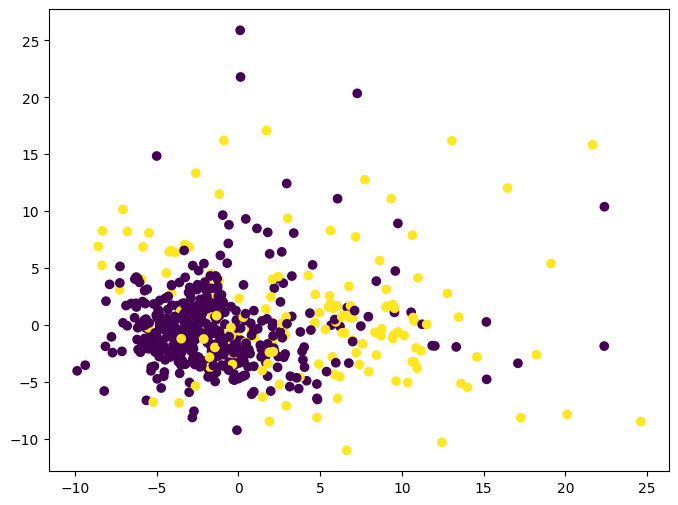

In [65]:
x_hybrid = np.empty((0,3))
x_hybrid_pca1 = x_hybrid_pca2 = y_hy2l = y_hy1l = np.empty((0))

# Scale and perform PCA for each subject
for features in feat_list: # cycle through each subject
    scaler_hy = StandardScaler().fit(features)
    X_train_hy = scaler_hy.transform(features)

    pca = PCA(n_components=4)
    pca.fit(X_train_hy)
    X_train_pcahy = pca.transform(X_train_hy)
    x_train_hy = X_train_pcahy[:,0:3] # Three best features
    x_hybrid = np.concatenate((x_hybrid, x_train_hy)) # add each scaled subject feature to x_hybrid
    x_hybrid_pca1 = np.concatenate((x_hybrid_pca1, X_train_pcahy[:,0]))
    x_hybrid_pca2 = np.concatenate((x_hybrid_pca2, X_train_pcahy[:,1]))
    y_hy1l = np.concatenate((y_hy1l, y_hy1))

plt.figure(figsize=(8,6))
plt.scatter(x_hybrid_pca1, x_hybrid_pca2, c=y_hy1l)

In [66]:
# Splitting the data in train and test data
X_train_hy, X_test_hy, y_train_hy, y_test_hy = train_test_split(x_hybrid, y_hy1l, test_size=0.2, random_state=5)

# Scaling the data
scaler_hy = StandardScaler().fit(X_train_hy)
X_train_hyy = scaler_hy.transform(X_train_hy)
X_test_hy = scaler_hy.transform(X_test_hy)

# Logistic regression
logistic_model_hy = LogisticRegression()
logistic_model_hy.fit(X_train_hy, y_train_hy)
Y_test_pred_hy = logistic_model_hy.predict(X_test_hy)
log_score_hy = logistic_model_hy.score(X_test_hy,y_test_hy)

# SVM
svm_model_hy = svm.SVC()
svm_model_hy.fit(X_train_hy, y_train_hy)
Y_test_pred_hy = svm_model_hy.predict(X_test_hy)
svm_score_hy = svm_model_hy.score(X_test_hy,y_test_hy)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# neural network
val_accuracies_hy = []
for i in range(5): # run 5 times with 5 random states to determine model accuracy
    # Splitting the data in train and test data
    X_trainn_hy, X_testn_hy, y_trainn_hy, y_testn_hy = train_test_split(x_hybrid, y_hy1l, test_size=0.2, random_state= i + 1)
    # Scaling the data
    scaler_hy = StandardScaler().fit(X_trainn_hy)
    X_trainn_hy = scaler_hy.transform(X_trainn_hy)
    X_testn_hy = scaler_hy.transform(X_testn_hy)
    ## Convert labels to categorical
    y_train_cat_hy = to_categorical(y_trainn_hy,3)
    y_test_cat_hy = to_categorical(y_testn_hy,3)
    # Define the feedforward neural network
    neural_model_hy = Sequential()
    neural_model_hy.add(Dense(128, activation='relu', input_shape=(3,)))
    neural_model_hy.add(Dense(128, activation='relu'))
    neural_model_hy.add(Dense(128, activation='relu'))
    neural_model_hy.add(Dense(128, activation = 'relu'))
    neural_model_hy.add(Dropout(0.5))
    neural_model_hy.add(Dense(3, activation='softmax'))
    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    neural_model_hy.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    # Train the model
    # history = model.fit(X_train_pca, y_train, validation_data=(X_test_pca, y_test), epochs=45, batch_size=100, verbose=2)
    history_hy = neural_model_hy.fit(X_trainn_hy, y_train_cat_hy, validation_data=(X_testn_hy, y_test_cat_hy), epochs=45, batch_size=100, verbose=0)
    val_accuracy_hy = history_hy.history['val_accuracy'][-1]
    val_accuracies_hy.append(val_accuracy_hy) # accuracy score
# print(val_accuracies)
avg_val_accuracy_hy = sum(val_accuracies_hy) / len(val_accuracies_hy) # average of accurracy scores
# print("Average Validation Accuracy:", avg_val_accuracy)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.legend(['accuracy', 'val_accuracy'])
#from sklearn.datasets import make_classification

# random forest
from sklearn.ensemble import RandomForestClassifier
# define the model
randomf_model_hy = RandomForestClassifier()
# fit/train the model on all features
randomf_model_hy.fit(X_train_hy, y_train_hy)
Y_test_pred_hy = randomf_model_hy.predict(X_test_hy)
#score
rf_score_hy = randomf_model_hy.score(X_test_hy, y_test_hy)


In [67]:
# calculate model scores
y_test_cat_hy = to_categorical(y_test_hy)
y_test1_hy = y_test_cat_hy.astype('int64')
testYarg = np.argmax(y_test1_hy, axis = 1)
def model_predict_neural(X_test, y_test1, model):
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis = 1)
    y_test1 = y_test1.astype('int64')
    testYarg = np.argmax(y_test1, axis = 1)
    miss_class = np.where(predictions != testYarg)
    miss_class = miss_class[0]
    # print("Neural network")
    # print("Predicted:",predictions)
    # print("Correct:  ",testYarg)
    # print("Index missclassified:", miss_class)
    # print("Score:", val_accuracy, "\n")
    return predictions, miss_class, testYarg
def model_predict(X_test, y_test1, model):
    predictions = model.predict(X_test)
    #y_test1 = y_test1.astype('int64')
    #testYarg = np.argmax(y_test1, axis = 1)
    miss_class = np.where(predictions != y_test1)
    miss_class = miss_class[0]
    score=model.score(X_test, y_test1)
    # print(model)
    # print("Predicted:",predictions)
    # print("Correct:  ",testYarg)
    # print("Index missclassified:", miss_class)
    # print("Score:", score, "\n")
    return predictions, miss_class, testYarg
# model_predict_neural(X_test, y_test_cat, neural_model)
# model_predict(X_test, y_test, logistic_model)
# model_predict(X_test, y_test, svm_model)
# predictions = model_predict(X_test, y_test, randomf_model)

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
def cross_validation(X, y, model, acc_d, std_d):
    cv = KFold(n_splits= 5, random_state=1, shuffle=True)
    scores = cross_val_score(model, X,y, scoring='accuracy', cv=cv, n_jobs=-1)
    # print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    # print(str(model))
    acc_hy[str(model)].append(mean(scores))
    std_hy[str(model)].append(std(scores))
    return scores
print("Logistic regression")
cv_logistic = cross_validation(x_hybrid, y_hy1l, logistic_model_hy, acc_hy, std_hy)
print(cv_logistic,"\n\nSVM")
cv_svm = cross_validation(x_hybrid, y_hy1l, svm_model_hy, acc_hy, std_hy)
print(cv_svm, "\n\nRandomforest")
cv_randomf = cross_validation(x_hybrid, y_hy1l, randomf_model_hy, acc_hy, std_hy)
print(cv_randomf, "\n\nNeural Network")
# print("Accuracy:", avg_val_accuracy)
print(val_accuracies_hy)
#print ('ACC std:', '{0:0.3f}'.format(np.std(val_accuracies)), "\n")
nnmean_hy.append(avg_val_accuracy_hy)
nnstd_hy.append(np.std(val_accuracies_hy))

Logistic regression
[0.775      0.84166667 0.8        0.75       0.825     ] 

SVM
[0.84166667 0.84166667 0.81666667 0.8        0.79166667] 

Randomforest
[0.81666667 0.85833333 0.81666667 0.81666667 0.83333333] 

Neural Network
[0.8333333134651184, 0.824999988079071, 0.7749999761581421, 0.8333333134651184, 0.7583333253860474]


In [68]:
print("Logistic regression")
print("{:.5f}".format(acc_hy['LogisticRegression()'][0]))
print("{:.5f}".format(std_hy['LogisticRegression()'][0]), "\n\nSVM")
print("{:.5f}".format(acc_hy['SVC()'][0]))
print("{:.5f}".format(std_hy['SVC()'][0]), "\n\nRandomforest")
print("{:.5f}".format(acc_hy['RandomForestClassifier()'][0]))
print("{:.5f}".format(std_hy['RandomForestClassifier()'][0]), "\n\nNeural Network")
print("{:.5f}".format(nnmean_hy[0]))
print("{:.5f}".format(nnstd_hy[0]))


Logistic regression
0.79833
0.03308 

SVM
0.81833
0.02068 

Randomforest
0.82833
0.01633 

Neural Network
0.80500
0.03189


Own Measurement

In [69]:
# Set up empty dataframes for the features
ecgfeaturestest = pd.DataFrame(None, columns= ['HR_mean', 'HR_min', 'HR_max', 'HR_std', 'SDNN', 'SDANN', 'RMSSD', 'SDSD','pNN50', 'pNN20', 
                                    'abs_power_VLF', 'abs_power_LF', 'abs_power_HF', 'tot_power', 'LF/HF', 
                                    'peak_vlf', 'peak_lf', 'peak_hf', 'norm_power_LF', 'norm_power_HF'])
edafeaturestest = None

# Reading from csv
data = pd.read_csv('First_Measurements.csv', index_col=0)
ecg = data['ECG Data']
eda = data['GSR Data']
fs =100
duration = 30
print(len(eda))

3346


In [70]:

# print(i * (duration*fs), (i+1)*(duration*fs))
# ecg = ecg_base[i * (duration*fs): (i+1)*(duration*fs)]
# eda = eda_base[i * (duration*fs): (i+1)*(duration*fs)]

# Set up empty dataframes for the features
ecgfeaturestest = pd.DataFrame(None, columns= ['HR_mean', 'HR_min', 'HR_max', 'HR_std', 'SDNN', 'SDANN', 'RMSSD', 'SDSD','pNN50', 'pNN20', 
                                    'abs_power_VLF', 'abs_power_LF', 'abs_power_HF', 'tot_power', 'LF/HF', 
                                    'peak_vlf', 'peak_lf', 'peak_hf', 'norm_power_LF', 'norm_power_HF'])
edafeaturestest = None

# Reading from csv
data = pd.read_csv('First_Measurements.csv', index_col=0)
ecg = data['ECG Data']
eda = data['GSR Data']
fs =100
duration = 30
print(len(eda))

index = '1'
tonic, phasic, start, end = get_edaindex(eda, fs)
edafeaturestest = get_edafeatures(index, edafeaturestest, phasic, tonic, fs)
ecgfeaturestest = get_ecgfeatures(ecg, fs, ecgfeaturestest, index)

total_featurestest = pd.merge(ecgfeaturestest, edafeaturestest, left_index=True, right_index=True)

3346


ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0

In [ ]:
total_featurestest = pd.merge(ecgfeaturestest, edafeaturestest, left_index=True, right_index=True)

features = total_featurestest

scaler = StandardScaler().fit(features)
X_train = scaler.transform(features)

pca = PCA(n_components=25)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
x_train = X_train_pca[:,0:3]

print(svm_model.predict())
print(logistic_model.predict())
print(randomf_model.predict())